# Random forests on mouse phenotype data

Today we will use one of the most popular supervised learning methods: random forests. It is an ensemble method, which means it uses multiple predictors and makes its final prediction based on a democratic vote of its individual predictors.

These sub-predictors are called decision trees, hence the name forest. Decision trees are labelled binary trees. Every leaf is associated with a class label, and every branching point is a test for a feature value against a threshold: if the feature value is smaller than the threshold, the sample is passed on towards the left branch, otherwise it continues on the right branch. The prediction is the label of the leaf it eventually reaches, starting from the tree's root.

Random forests generate a set of decision trees in a structured (but somewhat random) manner, and aggregate their results.

We will load the data as usual:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, recall_score, matthews_corrcoef, classification_report


In [2]:
import pandas as pd
phenotype = pd.read_excel('../example_data/aad0189_DataFileS2.xlsx', sheet_name=None, na_values='x', index_col='@format=column')

In [3]:
# The VO2Max table doesn't follow their own column naming conventions, so fix that first
def rename_vo2_cols(colname):
    return colname.replace('CD', 'CD_').replace('HFD', 'HFD_').replace('__', '_')

phenotype['VO2Max'].rename(columns=rename_vo2_cols, inplace=True)

def split_cd_hfd(input_df):
    input_df.index.name = 'strain'  # change that weird @format=column Excel index label to something meaningful
    input_cd = input_df.filter(regex=r'_CD|CD_') # loc[:, (input_df.columns.str.contains('CD_')) | (input_df.columns.str.contains('_CD'))]
    input_hfd = input_df.filter(regex=r'_HFD|HFD_') #loc[:, (input_df.columns.str.contains('HFD_')) | (input_df.columns.str.contains('_HFD'))]

    input_cd.columns = input_cd.columns.str.replace(r'_CD|CD_', '')
    input_hfd.columns = input_hfd.columns.str.replace(r'_HFD|HFD_', '')
    
    input_cd.insert(0, 'diet', 'CD')
    input_hfd.insert(0, 'diet', 'HFD')
    
    kept_columns = input_cd.columns.intersection(input_hfd.columns)
    
    df_both = pd.concat([input_cd, input_hfd], sort=False)[kept_columns]
    df_both.columns.name = 'experiment'  # added only later
    
    return df_both.reset_index().set_index(['strain', 'diet']).sort_index()

In [4]:
pheno = pd.concat([split_cd_hfd(sheet) for sheet_name, sheet in phenotype.items() if sheet_name != "NEW"], axis=1)

# let's remove the main offenders for missing values, both samples and features
pheno = pheno.loc[pheno.T.isna().sum() < 42]  # samples with lots of missing features
pheno = pheno.loc[:, pheno.isna().sum() < 11]  # features with still too many missing values

# a peek at what missing data we are left with:
# sns.clustermap(pheno.isna(), figsize=(10,10))

In [5]:
# Remove too informative columns for the sake of a more challenging classification task
banned = ["KNOWN_BATCH_EFFECT_BY_COHORT_ORDER", "BWGain", "Mass", "BodyWeight", "Food", "Sacrifice"]
kept_cols = [x for x in pheno.columns if all(b not in x for b in banned)]

data_raw = pheno.loc[:, kept_cols]

Imputing missing values:

In [6]:
imputer = SimpleImputer(strategy='median')
data = pd.DataFrame(imputer.fit_transform(data_raw), index=data_raw.index, columns=data_raw.columns)

In [7]:
data = data_raw.fillna(data.median())

In [8]:
target = data.index.to_frame()['diet'].replace({'CD': 0, 'HFD': 1})

### 1.1: Use and evaluate a random forest classifier

Create a `RandomForestClassifier` with 10 trees and otherwise default settings. Calculate its accuracy on `data` with `cross_val_score`. You can use whatever cross-validation class you prefer.

You hopefully found that the random forest was very accurate even though we skipped the data standardization step. This is in stark contrast with yesterday's SVMs which performed poorly on unnormalized data.

Random forests are one of the few machine learning algorithms that don't require or benefit from standardization, since decision trees look at individual features (and calculate split point values) independently, and therefore it doesn't matter if the features' scaling is different.

In [9]:
# Random forest classifier
rf = RandomForestClassifier(n_estimators=10)
rf.fit(data, target)

# Cross validation
cross_val_score(rf, data, target, cv=StratifiedKFold(3)).mean()

0.9436781609195402

### 1.2: Re-run the previous cell a few times

Why does the accuracy figure jump around?

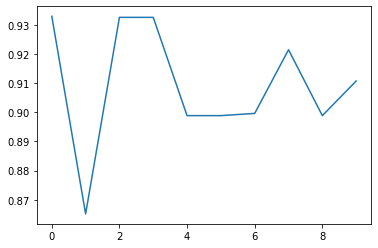

In [10]:
# Re-run
acc = []
for i in range(10):
    rf = RandomForestClassifier(n_estimators=10)
    rf.fit(data, target)
    rf.score(data, target)

    acc.append(cross_val_score(rf, data, target, cv=StratifiedKFold(3)).mean())

plt.plot(acc)

### 1.3: Get a more precise accuracy figure with repeated, shuffled cross-validation

Your model's accuracy is just an estimate. Even if you evaluate it on the exact same data, you may still get different values each time due to the inherent randomness of the model, or the cross-validation folds that you get (due to different number of folds, or shuffling).

The `RepeatedKFold` or `RepeatedStratifiedKFold` classes help you arrive at a more precise accuracy figure by doing many rounds of shuffled cross-validation, all you have to do is average the fold accuracies at the end.

You can use the good old `cross_val_score` method with the `cv=RepeatedStratifiedKFold(3, n_repeats=10)` keyword.

Note: repeated cross-validators only work with `cross_val_score` but not `cross_val_predict`, since the latter method insists on returning only a single prediction label for each sample.

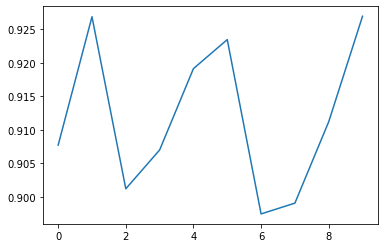

In [11]:
import warnings
warnings.filterwarnings('ignore')

# Calculate with cv=RepeatedStratifiedKFold(3, n_repeats=10)
acc = []
for i in range(10):
    rf = RandomForestClassifier(n_estimators=10)
    rf.fit(data, target)

    acc.append(cross_val_score(rf, data, target, cv=RepeatedStratifiedKFold(3, n_repeats=10)).mean())

plt.plot(acc)

### 1.4: Determine the uncertainty of the accuracy

We now have a more accurate estimation for the mean of the model's accuracy, but this accuracy will not be achieved with every instance of the model. We should also try to determine the error bars around that accuracy value. Therefore we should take a closer look at the distribution of the accuracies from different instances of the model.

Use `cv=StratifiedKFold(3, shuffle=True)` this time, so that we have one accuracy value for each pass over the dataset. Run `cross_val_score` 100 times inside a `for` loop, save the 100 accuracy values that you get into a list, and plot the histogram of the resulting accuracy values.

What is the 90% confidence interval of the model's accuracy? (What is a "confidence interval" to begin with?)

The function `np.percentile` can help you calculate the confidence interval. Put the lower and upper bounds of the confidence interval on the histogram as two vertical lines with `plt.axvline(...)`.

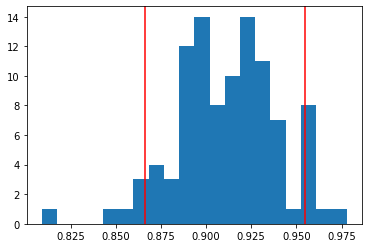

CONFIDENCE INTERVAL FROM 0.8658812260536397 TO 0.9547892720306513


In [12]:
# Calculate uncertainty accuracy 
acc = []
rf = RandomForestClassifier(n_estimators=10)
rf.fit(data, target)
for i in range(100):
    acc.append(cross_val_score(rf, data, target, cv=StratifiedKFold(3, shuffle=True)).mean())
    
lower = np.percentile(acc, 5)
upper = np.percentile(acc, 95)

plt.hist(acc, bins=20)    
plt.axvline(lower, c='red')
plt.axvline(upper, c='red')
plt.show()
print('CONFIDENCE INTERVAL FROM', lower, "TO", upper)

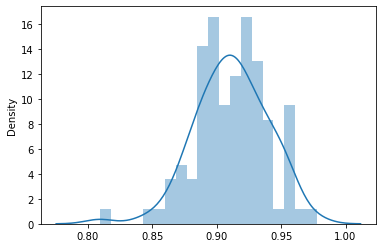

CONFIDENCE INTERVAL FROM 0.8658812260536397 TO 0.9547892720306513


In [13]:
sns.distplot(acc, bins=20, hist=True)    
plt.show()
print('CONFIDENCE INTERVAL FROM', lower, "TO", upper)

### 1.5: Plot a single random forest's internal prediction probability values

`RandomForestClassifier`s have a `predict_proba` method by default, similar to `SVC`s with `proability=True` turned on. Use the convencience function `cross_val_predict` to get class membership probability estimates for each sample. Create a histogram of the probability values for HFD (second column).

Use 100 bins for the histogram. Why are the probability values so rough? What are they derived from?
-  They are so rough because each forest "votes" for one class label and with default amount of trees of 10 you get those values

Optional: Mark CD and HFD samples on the histogram with different colors. `plt.hist` can accept multiple arrays of values to plot, and present them on the same histogram with the `histtype='barstacked'` setting. For this, you first have to slice the probability values into two pieces based on `target` values.

- because in decision tree strategy, the result is discrete

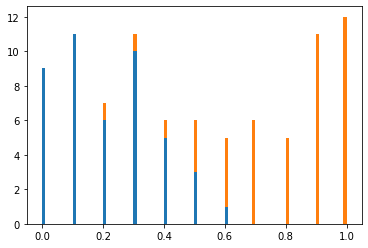

In [14]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(data, target)

# Calculate confidence interval
internal_pred = cross_val_predict(rf, data, target, cv=StratifiedKFold(n_splits=3, shuffle=True), method='predict_proba')
internal_pred_hfd = pd.Series(internal_pred[:,1], index=data.index)

# plot hisgram
plt.hist([internal_pred_hfd.loc[target==0], internal_pred_hfd.loc[target==1]], histtype='barstacked', bins=100)
plt.show()

### 1.6: Visualize a decision tree

We have installed the decision tree visualization package `dtreeviz`. All you have to do is
 * fit a random forest (you can do it with the entire dataset)
 * find where it stores its individual decision trees
 * pick any one of them, and pass it to dtreeviz

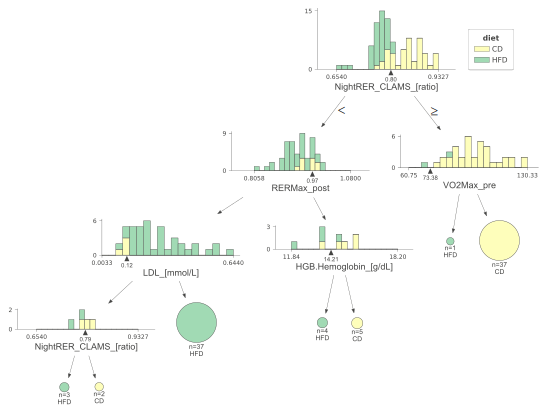

In [15]:
from dtreeviz.trees import dtreeviz

# set random forest
rf = RandomForestClassifier(20)
rf.fit(data, target)

# plot with dtreeviz function
a_decision_tree = rf.estimators_[5]
dtreeviz(a_decision_tree, data, target, feature_names=data.columns, target_name="diet", class_names=['CD', 'HFD'])

### 1.7: Increase the number of trees and limit their depth

Make a random forest classifier with a 1000 trees. Limit their depth to 3.

Plot a label probability histogram like you did in 1.5. Do the probability values look more continuous now?

Visualize a few trees again (no need to keep them all in the notebook, re-running the same cell is fine). Did anything change compared to last time?

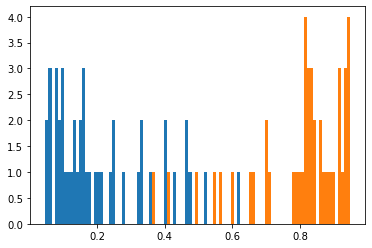

In [16]:
# Make a random forest classifier with a 1000 trees. Limit their depth to 3.
rf = RandomForestClassifier(n_estimators=1000, max_depth=3)
rf.fit(data, target)

# Calculate confidence interval
internal_pred = cross_val_predict(rf, data, target, cv=StratifiedKFold(n_splits=3, shuffle=True), method='predict_proba')
internal_pred_hfd = pd.Series(internal_pred[:,1], index=data.index)

# plot hisgram
plt.hist([internal_pred_hfd.loc[target==0], internal_pred_hfd.loc[target==1]], histtype='barstacked', bins=100)
plt.show()

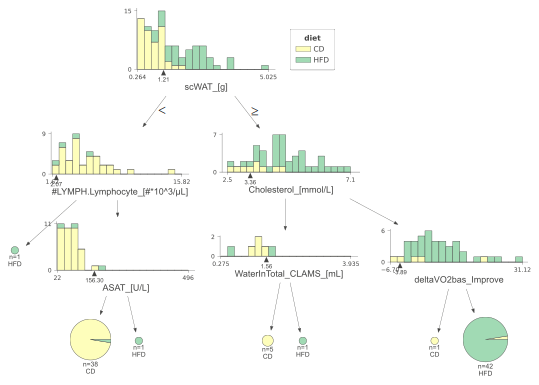

In [17]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=3)
rf.fit(data, target)

# plot with dtreeviz function
a_decision_tree = rf.estimators_[500]
dtreeviz(a_decision_tree, data, target, feature_names=data.columns, target_name="diet", class_names=['CD', 'HFD'])

### 1.8: Create a ROC curve
Now that you know how to access the continuous internal prediction variables (class membership probability in this case) you can create a ROC plot easily.

Optional: Generate a bunch of ROC curve values and plot their "average".

Text(0, 0.5, 'sensitivity')

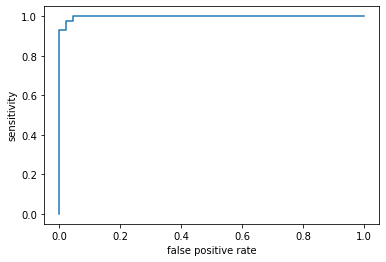

In [18]:
# Calculate confidence interval
internal_pred = cross_val_predict(rf, data, target, cv=StratifiedKFold(n_splits=3, shuffle=True), method='predict_proba')
internal_pred_hfd = pd.Series(internal_pred[:,1], index=data.index)

# Calculate false/ture positive rate for CD
fpr, tpr, thresholds = roc_curve(target, internal_pred_hfd)

# plot the dot chart
plt.plot(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('sensitivity')

### 1.9: Feature importances

Random forests utilize their internal structure not just to provide probability estimates, but also to estimate the importance of different features. Therefore random forests are popular not just for prediction models but also for general data exploration.

How do you think feature importances are derived?

Find a way to access the feature importance values, turn it into a Series with the feature names as the index (found in `data.columns`), and sort them from best to last. Are the winners familiar from yesterday?

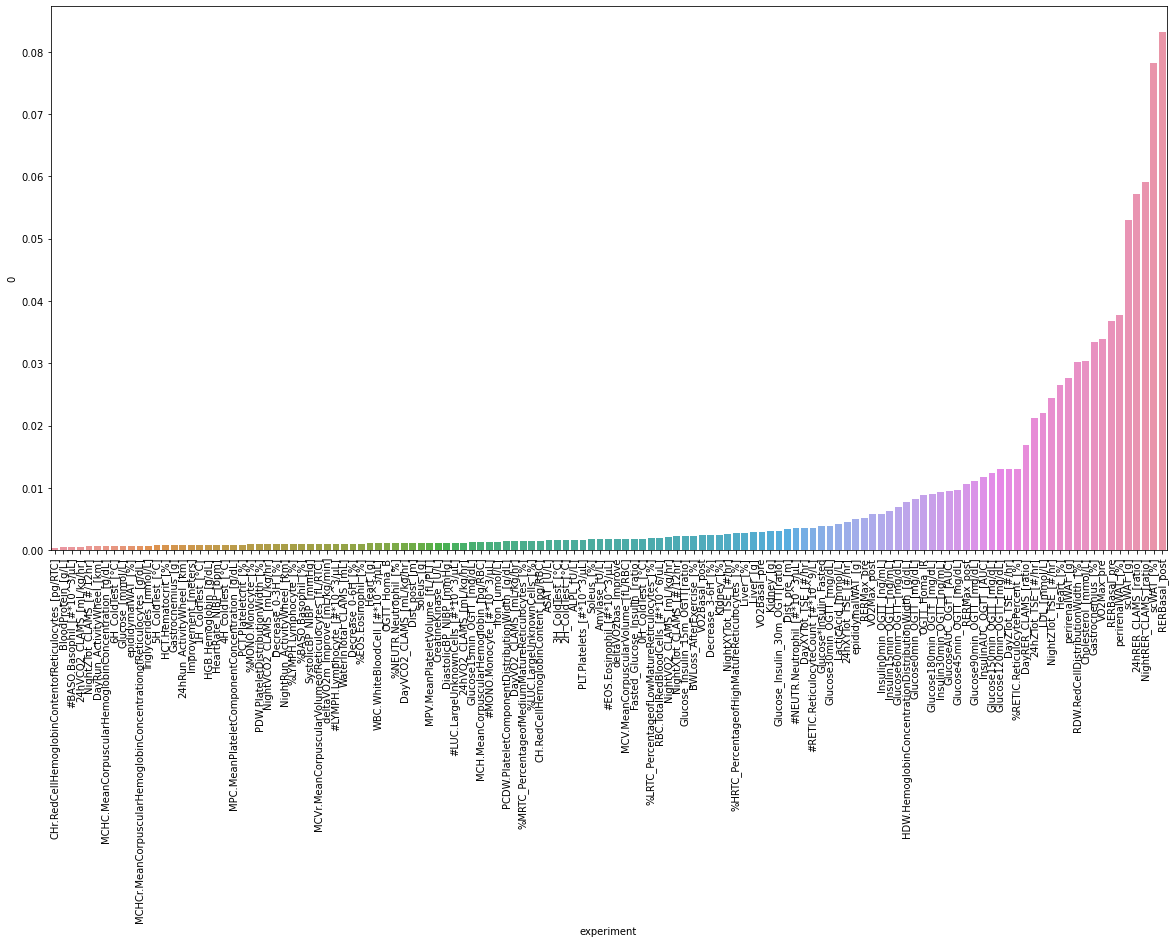

In [19]:
# Import the feature importance
importances = rf.feature_importances_
import_frame = pd.DataFrame(importances, index=data.columns)
import_sort = import_frame.sort_values(0)

# plot the bar chart
plt.figure(figsize=(20,10))
sns.barplot(import_sort.index, y=import_sort[0])
plt.xticks(rotation=90)
plt.show()


### 1.10: Play around

Ideas:

* Random Forests use a lot of randomization for the generation of each decision tree. You have some control over  this with parameters like `max_features` and `max_samples`. Look at these (or other) parameters and try to improve the accuracy of an RFC by trying out different combinations.
* Feature selection: Look for correlations in the features, search for clusters among them and choose one representative feature per cluster. Try to achieve high accuracy with just a few features.
* Eliminate obvious features and test how the model performs without them. Add (or since we use linear, un-normalized features: multiply) noise to the data.

Random Forests use a lot of randomization for the generation of each decision tree. You have some control over this with parameters like max_features and max_samples. Look at these (or other) parameters and try to improve the accuracy of an RFC by trying out different combinations.

In [20]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=3, max_features='sqrt')
rf.fit(data, target)

cross_val_score(rf, data, target, cv=RepeatedStratifiedKFold(3, n_repeats=10)).mean()

0.949463601532567

Eliminate obvious features and test how the model performs without them

In [21]:
importances = rf.feature_importances_
import_frame = pd.DataFrame(importances, index=data.columns)
import_best = import_frame.sort_values(0, ascending=False)[:10]
data_best = data.loc[:, import_best.index]
import_best

,0
experiment,
RERBasal_post,0.086741
scWAT_[%],0.077057
NightRER_CLAMS_[ratio],0.072462
24hRER_CLAMS_[ratio],0.051056
scWAT_[g],0.047270
perirenalWAT_[%],0.044199
RERBasal_pre,0.035909
VO2Max_pre,0.032747
perirenalWAT_[g],0.031320


In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data)
data_std = pd.DataFrame(scaler.transform(data), index = data.index, columns=data.columns)
no_best_data = data_std.drop(import_best.index, axis=1)

In [23]:
rf_no_best = RandomForestClassifier(n_estimators=1000, max_depth=3, max_features='sqrt')
rf_no_best.fit(no_best_data, target)
cross_val_score(rf_no_best, no_best_data, target, cv=StratifiedKFold(3)).mean()

0.8770114942528736

Feature selection: Look for correlations in the features, search for clusters among them and choose one representative feature per cluster. Try to achieve high accuracy with just a few features.

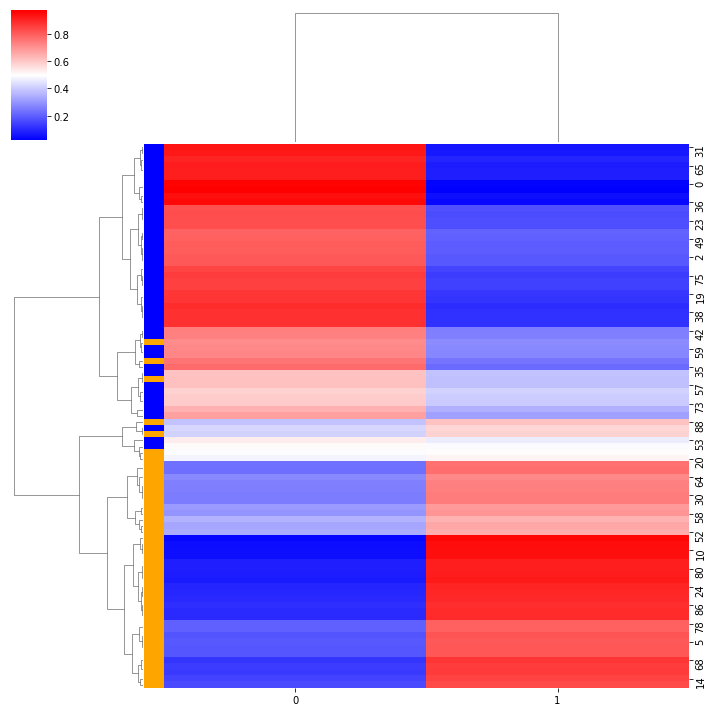

In [24]:
label_prob = cross_val_predict(rf, data, target, cv=StratifiedKFold(n_splits=3, shuffle=True), method='predict_proba')
colors = ['blue' if diet=='CD' else 'orange' for diet in data.index.get_level_values(level='diet')]
sns.clustermap(label_prob, cmap='bwr', row_colors=colors)

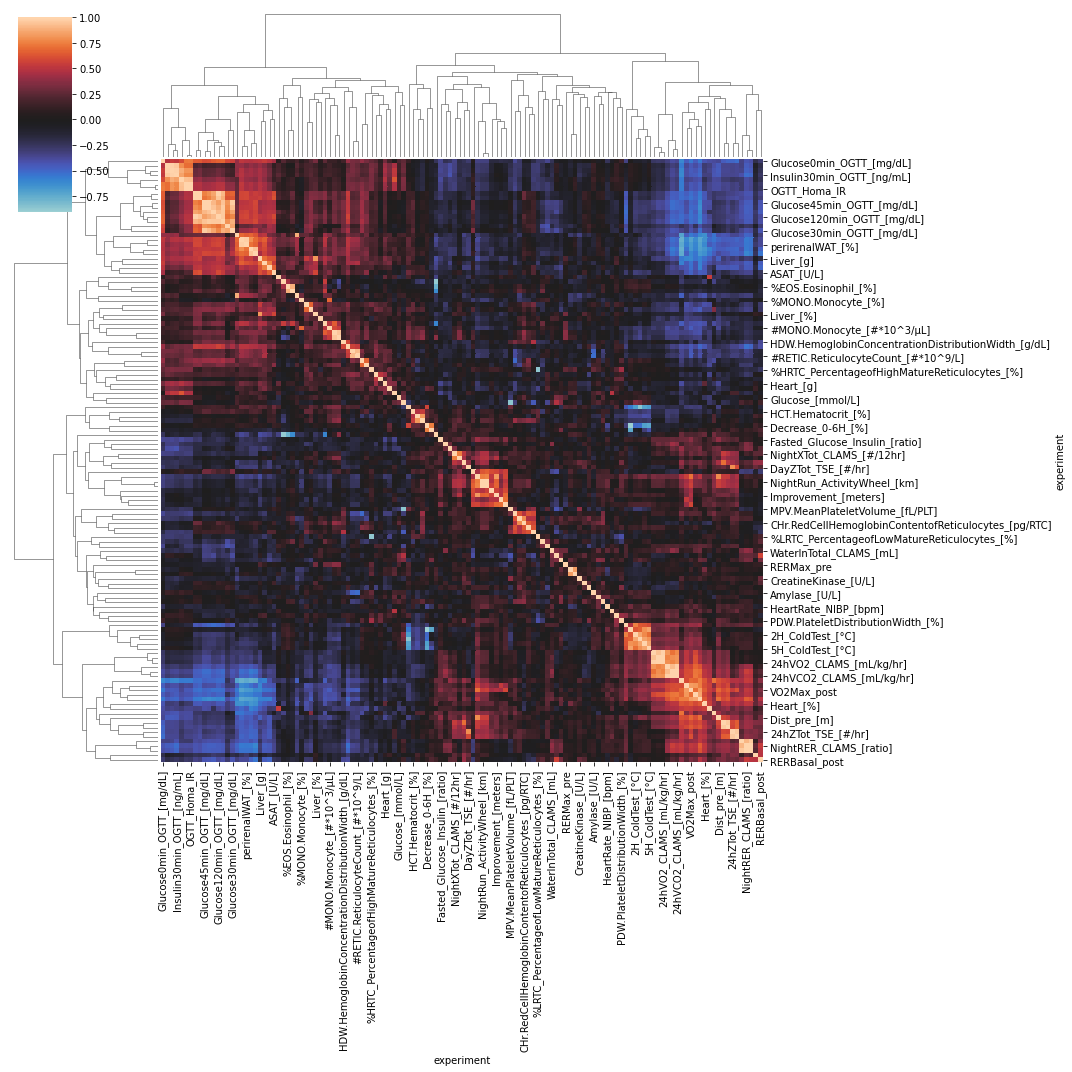

In [25]:
sns.clustermap(data_std.iloc[:,:-1].corr(), center=0,figsize=(15,15))
plt.show()

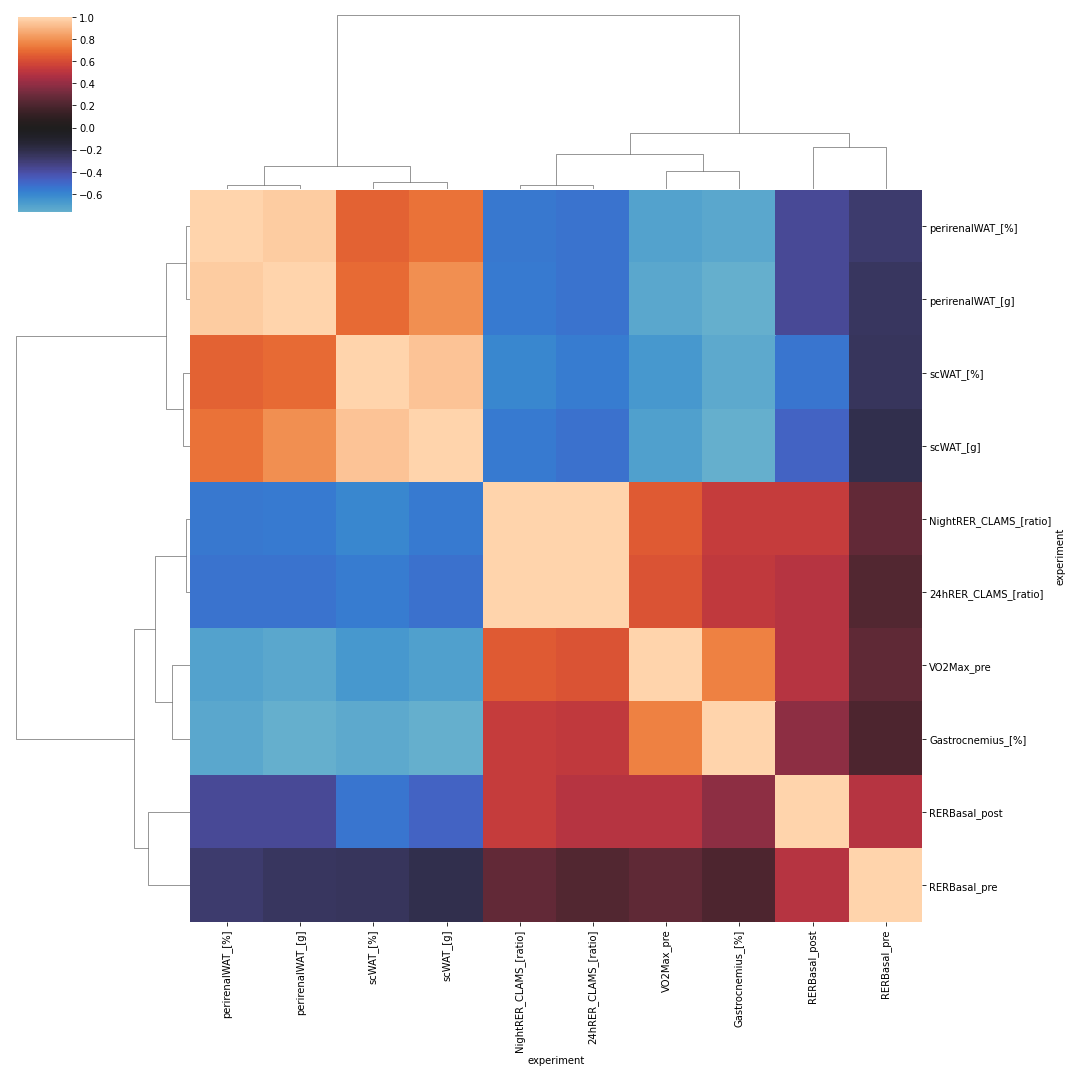

In [26]:
sns.clustermap(data_best.corr(), center=0,figsize=(15,15))
plt.show()

Here I find something interesting, the best 10 feature can roughly represent the whole feature correlation, and it say random forest really successfully reduce the dimension and didn't lost too much information.